## IMPORTS

In [1]:
import os
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## DEFINES

In [2]:
def getObjnImgPoints(images, nx=9, ny=6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.    
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgxy = (gray.shape[1], gray.shape[0])
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints, corners, imgxy
            
def undistortImage(img, mtx, dist): #img is gray image
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def calibrateCamera(img, objpoints, imgpoint): #img is gray image
    img_size = img.shape[0:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    return ret, mtx, dist, rvecs, tvecs


def unWarpImage(unDistImg, srcPts, dstPts, imgxy):
    
    M = cv2.getPerspectiveTransform(srcPts, dstPts)
    Minv = cv2.getPerspectiveTransform(dstPts, srcPts)
    #print(M)
    warpImg = cv2.warpPerspective(unDistImg, M, imgxy, flags=cv2.INTER_LINEAR)
    return warpImg, M, Minv

def getHLSChannelImages(image):
    hlsImg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hlsImg[:,:,0]
    L = hlsImg[:,:,1]
    S = hlsImg[:,:,2]
    return H, L, S

def getColorChannelImages(image):
    H = image[:,:,0]
    L = image[:,:,1]
    S = image[:,:,2]
    return H, L, S

def colorThreshold(img, tLow=120, tHigh=255):
    #binary_output = np.zeros_like(img)
    binary_output = (img > tLow) & (img <= tHigh)
    # Return a binary image of threshold result
    return binary_output

def absSobelXTreshold(grayimg, kernelSize=7, tLow=0, tHigh=255):
    img = np.copy(grayimg)
    #Take the derivative in x 
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    #Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= tLow) & (scaled_sobel <= tHigh)] = 1
    
    return sxbinary

def magSobelThreshold(grayimg, kernelSize=7, tLow=0, tHigh=255):
    img = np.copy(grayimg)
    # Apply the following steps to img
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0) #x
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1) #y
    # Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= tLow) & (scaled_sobel <= tHigh)] = 1
    
    return sxbinary

def directionalSobelThreshold(grayimg, kernelSize=7, tLow=0, tHigh=np.pi/2):
    img = np.copy(grayimg)
    # Take the gradient in x and y separately
    sblX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernelSize)
    sblY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernelSize)
    # Take the absolute value of the x and y gradients
    AsblX = np.absolute(sblX)
    AsblY = np.absolute(sblY)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctXY = np.arctan2(AsblY, AsblX)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arctXY)    
    # Return this mask as your binary_output image
    binary_output[(arctXY >= tLow) & (arctXY <= tHigh)] = 1
    return binary_output

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def sliding_window_polyfit(img):

        # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #for test3.jpg image, I was running into a problem where the algo was identifying
    #third lane as valid lane. I had not masked the region, so I decided to minimize my 
    #search for lane to the half of half
    mid_midpoint = np.int(midpoint//2)
   
    #Had to modify left and right bases to reflect mid_midpoints
    leftx_base = np.argmax(histogram[mid_midpoint:midpoint]) + mid_midpoint
    rightx_base = np.argmax(histogram[midpoint:(midpoint+mid_midpoint)]) + midpoint
    
          
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50# Choose the number of sliding windows
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    Windows = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        Windows.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    WindowsNHist = (Windows, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, WindowsNHist

def search_around_poly(binary_warped, left_fit, right_fit, margin=100):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    #print(len(left_lane_inds))
    

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fitx = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fitx = np.polyfit(righty, rightx, 2)
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds

def ProcessImage(img, mtx, dist, srcPts, dstPts, srcPtsInt):
   
    #1: Undistort the image
    testUndist = undistortImage(img, mtx, dist)
    
    #2: Unwarp the image
    testWarpImg, M, Minv = unWarpImage(testUndist, srcPts, dstPts, imgxy)
    
    #3: Color transforms
    #3.1: Gray scale of the image
    testWarpImgGray = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2GRAY)
    
    #3.2: HLS transform of the image
    testWarpImgHLS = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2HLS)    
    H, L, S = getColorChannelImages(testWarpImgHLS)
    
    #3.3: lAB transform of the image
    testWarpImgLAB = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2Lab)
    L, A, B = getColorChannelImages(testWarpImgLAB)
    
    #3.4: RYB transform of the image
    testWarpImgLAB = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2Lab)
    L, A, B = getColorChannelImages(testWarpImgLAB)
    
    
    #3.4: Color threshold
    #Normalize L image: for filtering Yellow lines
    LNorm = L*(255/np.max(L))
    LThresh = colorThreshold(L, tLow=210, tHigh=255) #210, 255
    
    SThresh = colorThreshold(S, tLow=150, tHigh=255)
    
    #Normalize only for non-yellow lines
    if np.max(B) > 175:
        BNorm = B*(255/np.max(B))
    else:
        BNorm = np.copy(B)
        
    BThresh = colorThreshold(BNorm, tLow=183, tHigh=255) #160 220
    

    combined = np.zeros_like(LThresh)
    #combined[(LThresh == 1) | (SThresh == 1) | (BThresh == 1)] = 1
    combined[(LThresh == 1) | (BThresh == 1)] = 1
    
    return combined, M, Minv

def getRWCurvePoly(img, ym_per_pix, xm_per_pix, l_lane_inds, r_lane_inds):
   
    imgxy = img.shape
    ploty = np.linspace(0, imgxy[0]-1, imgxy[0])# to cover same y-range as image
    # Identify the x and y positions of all nonzero pixels in the image
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, in example, we created the data, but in our case we actually have those points readily available
    #Using them to create the leftx, lefty, rightx and righty
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    else: 
        right_fit_cr = []
        left_fit_cr = []        
    
    return ploty, left_fit_cr, right_fit_cr

def measure_curvature_real(img, left_lane_inds, right_lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = getRWCurvePoly(img, ym_per_pix, xm_per_pix, left_lane_inds, right_lane_inds)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    
    if len(left_fit_cr)>0:
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    else: 
        left_curverad = 0
        right_curverad = 0
    
    
    return left_curverad, right_curverad

#calculate lane offset
def CalcVehLaneOffset(img, left_fit, right_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if (not((len(left_fit)==0) and (len(right_fit) == 0))):
        imgxy = img.shape    
        ImgCenterPt = imgxy[1]/2
        LeftLanePos  = left_fit[0]*imgxy[0]**2 + left_fit[1]*imgxy[0] + left_fit[2]        
        RightLanePos = right_fit[0]*imgxy[0]**2 + right_fit[1]*imgxy[0] + right_fit[2]
        LaneCenterPoint = (RightLanePos + LeftLanePos)/2        
        Offset = ImgCenterPt - LaneCenterPoint
        return Offset*xm_per_pix


def plotLinesOnFrame(OrigFrame, warpBinImg, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warpBinImg).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    imgxy = warpBinImg.shape
    ploty = np.linspace(0, imgxy[0]-1, num=imgxy[0])# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imgxy[1], imgxy[0]))
    
    outImg = np.copy(OrigFrame)
    # Combine the result with the original image
    outFrame = cv2.addWeighted(outImg, 1, newwarp, 0.5, 0)
    
    return outFrame

def printVehRoadData(img, roadRad, VehOffset):
    outImg = np.copy(img)
    imgxy = img.shape       

    if VehOffset < 0:        
        VehPos = 'left'
    else:
        VehPos = 'right'
    
    cv2.putText(outImg, 'Curve radius: ' + '{:04.2f}'.format(roadRad) + 'm', (300, 80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 0),2, lineType=cv2.LINE_AA) 
    cv2.putText(outImg, 'Vehicle is : ' + '{:04.2f}'.format(abs(VehOffset)) + 'm ' + VehPos + ' of center', (200, 150), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 0),2, lineType=cv2.LINE_AA) 
     
    return outImg

def processVideoFrame(img):
    #mtx, dist are defined earlier (camera calibration)
    #src and dst points defined below (for completeness)
    if 0: 
        outImg = img
    else:     
        OrigFrame = np.copy(img)
        #Process Image
        warpBinImg, M, Minv = ProcessImage(img , mtx, dist, srcPts, dstPts, srcPtsInt)

        if not leftLine.detected or not rightLine.detected:            
            # either lines not detected, use the sliding window            
            left_fit, right_fit, left_lane_inds, right_lane_inds, WindowsNHist = sliding_window_polyfit(warpBinImg)
        else:             
            #lines detected earlier, use the polynomial fit method
            left_fit, right_fit, left_lane_inds, right_lane_inds = search_around_poly(warpBinImg, leftLine.best_fit, rightLine.best_fit, margin=100)            

        #These detections need to gaurded against bad detections
        #Maybe implement it later for now just continue by adding these detected line to object
        
        leftLine.UpdateLineInfo(left_fit)
        rightLine.UpdateLineInfo(right_fit)
               

        #Time to draw the lines on the image (both should have best fit)        
        if leftLine.best_fit is not None and rightLine.best_fit is not None: 
            #print('here')
            #calculate curvatures
            leftRad, rightRad = measure_curvature_real(warpBinImg, left_lane_inds, right_lane_inds)
            #calculate vehicle offset from center
            VehOffset = CalcVehLaneOffset(warpBinImg, leftLine.best_fit, rightLine.best_fit)
            #plot the lines on original image        
            outFrame = plotLinesOnFrame(OrigFrame, warpBinImg, leftLine.best_fit, rightLine.best_fit, Minv)
            #print out the curvature data
            outImg = printVehRoadData(outFrame, (leftRad+rightRad)/2, VehOffset)
        else: 
            #print('not here')
            outImg = img;
        
    return outImg

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #History points
        self.NFrame = 7
    
    def UpdateLineInfo(self, LineFit):
        # If the LineFit is present, add it: But check for various conditions
        if LineFit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(LineFit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                #This is not the first fit (there have been previous fits), so ignore this fit
                self.detected = False
            else:
                #however, if this is indeed the first fit, then add it 
                self.detected = True                
                self.current_fit.append(LineFit)
                if len(self.current_fit) > self.NFrame: 
                    #keeping latest 7 fits
                    self.current_fit = self.current_fit[len(self.current_fit)-self.NFrame:] 
                
                # Average out the current_fit for the best fit    
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

                
def displayImages(imgs, cmap=None, ImgTitles=None, nCols=3):
    numImg = len(imgs)
    
    nRows, bal = divmod(numImg, nCols)
    
    if bal:
        nRows = nRows+1
        
    fig, axs = plt.subplots(nRows,nCols, figsize=(16, nRows*4))
    fig.subplots_adjust(hspace = 0.02, wspace=0.01)
    axs = axs.ravel()
    for i, image in enumerate(imgs):
        axs[i].imshow(image, cmap)
        axs[i].set_title(ImgTitles[i])
        
    return


## CAMERA CALIBRATION

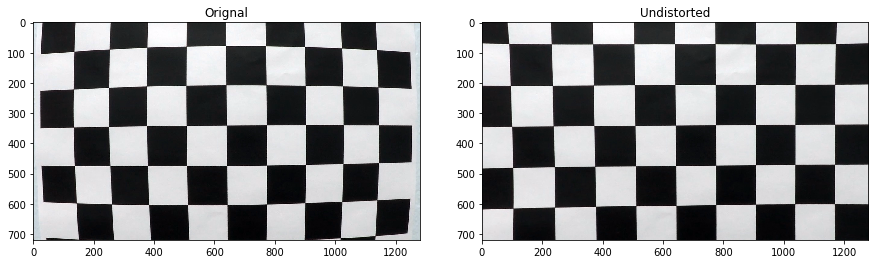

In [3]:
# Make a list of calibration images
imgList = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6
objpoints, imgpoints, corners, imgxy = getObjnImgPoints(imgList, nx, ny) #names of images   

#load camera calibration image pass them to this
testCalImg ='camera_cal/calibration1.jpg'
unDistImg ='output_images/undistort_output.jpg'

img = cv2.imread(testCalImg)
ret, mtx, dist, rvecs, tvecs = calibrateCamera(img, objpoints, imgpoints)

#undistort checkerboard image above using paramters returned above
undist = undistortImage(img, mtx, dist)
cv2.imwrite(unDistImg, undist)

#for plotting
imgs = []
imgTitles = []
imgs.append(img)
imgTitles = "Orignal"
imgs.append(undist)
imgTitles = [imgTitles, "Undistorted"]

displayImages(imgs[0:2],None, imgTitles[0:2], nCols=2)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )


## UNDISTORT

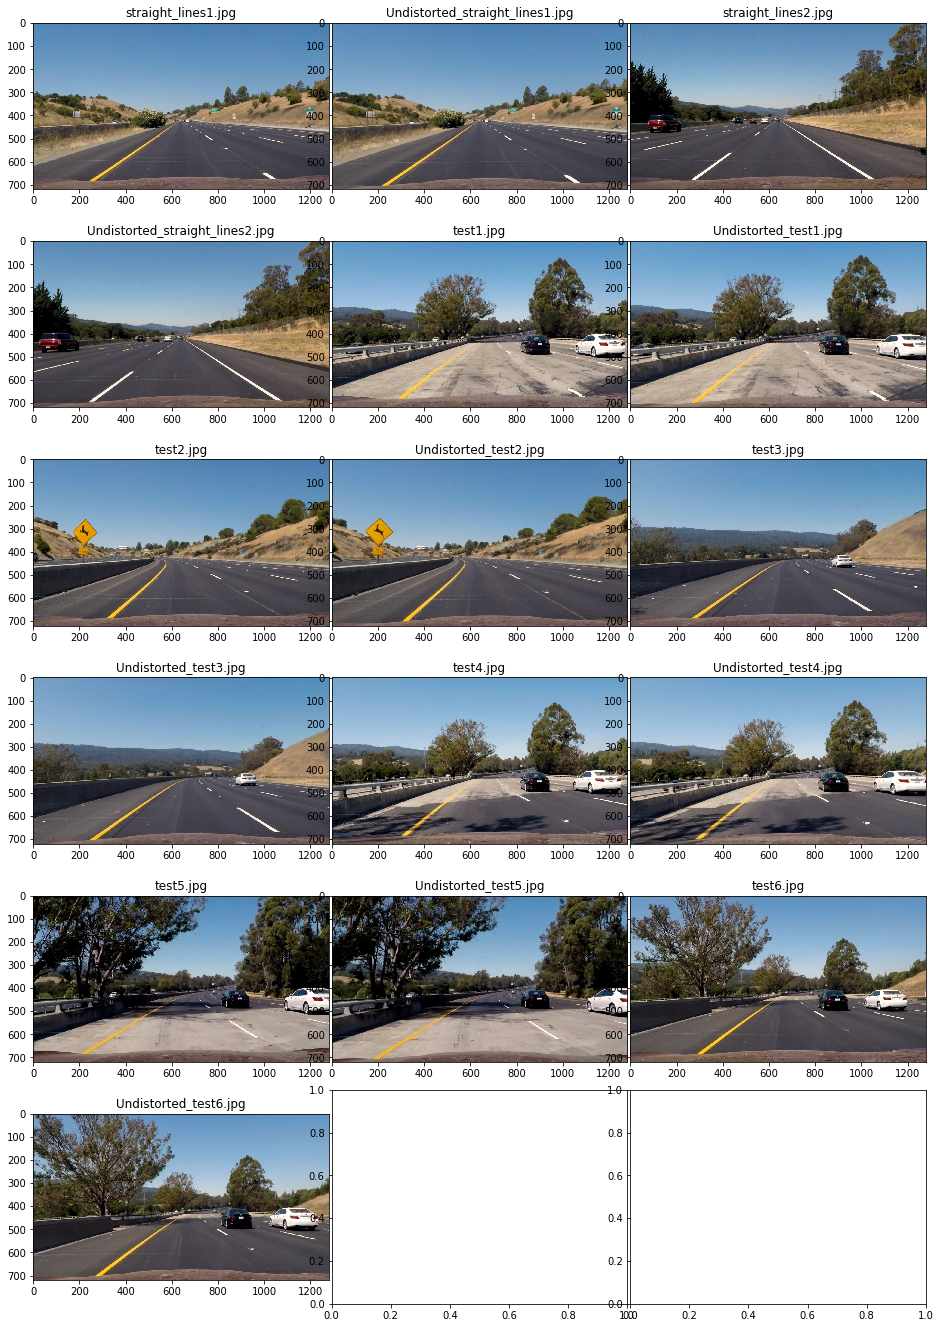

In [4]:
#Do undistort for all example images (start with 1)
testCalImg ='test_images/straight_lines1.jpg'
unDistImg ='output_images/straight_lines1_output.jpg'

fileNames = os.listdir("test_images/")
images = []
imgTitles = []
imgNames = []
unDistImgs = []

for imgName in fileNames:    
    
    imgNames.append(imgName)
    
    img = mpimg.imread("test_images/"+imgName)
    images.append(img)
    
    undist = undistortImage(img, mtx, dist)
    
    images.append(undist)
    unDistImgs.append(undist)
    imgNames.append("Undistorted_"+imgName)    

displayImages(images,None, imgNames)

## WARP IMAGES

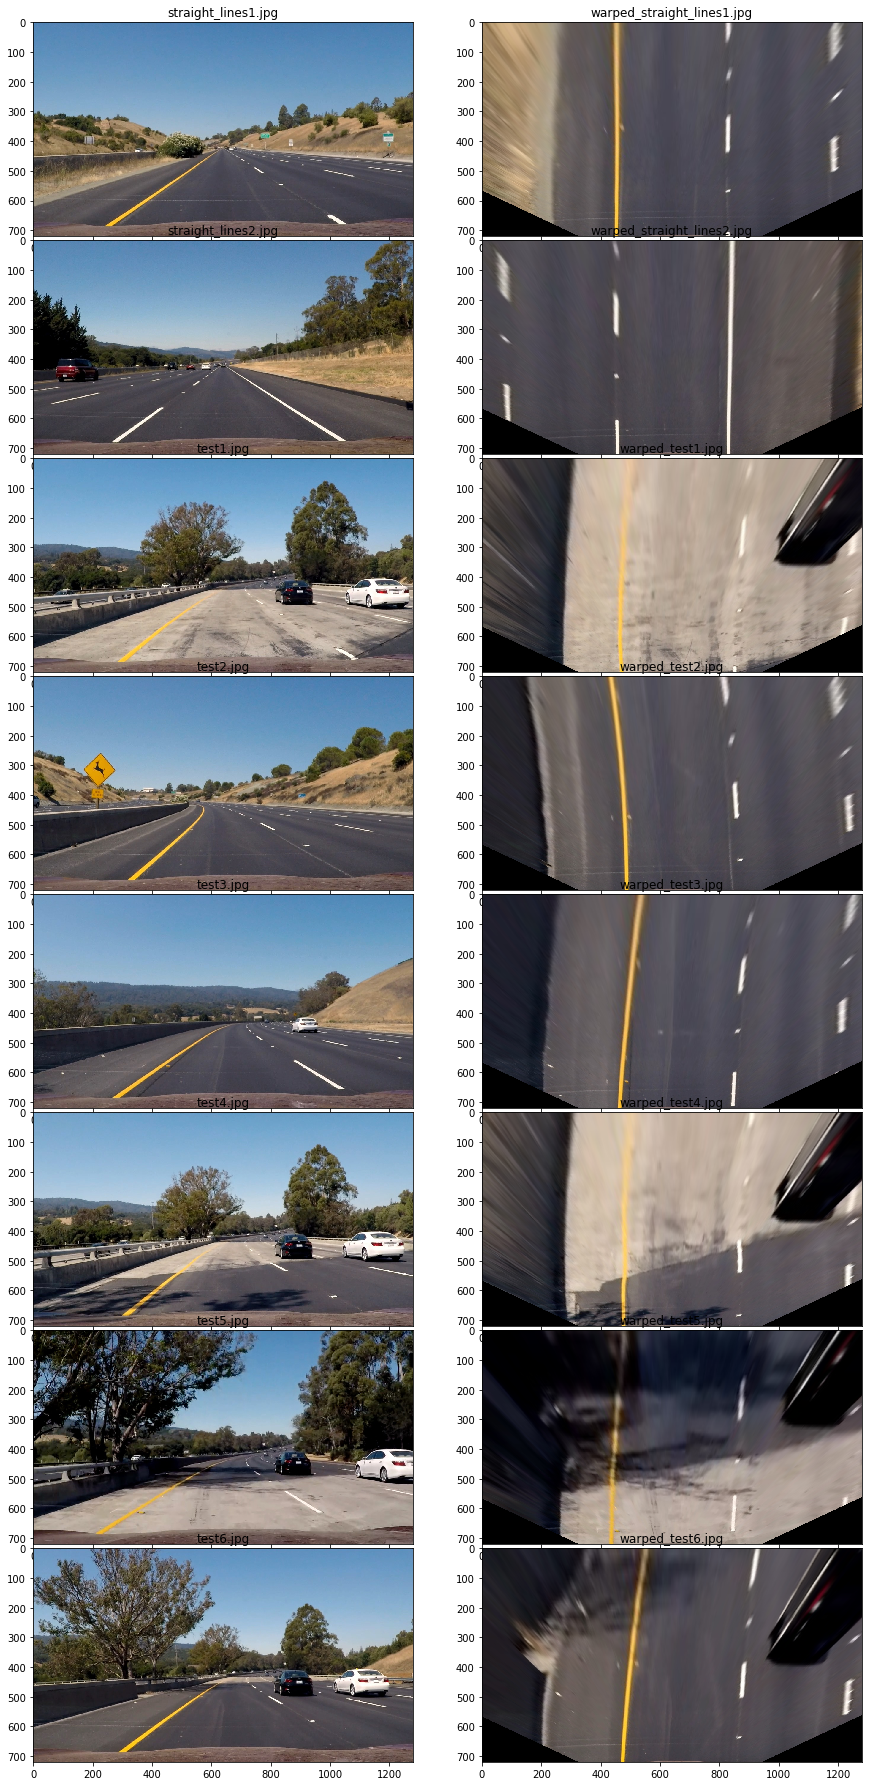

In [5]:
warpImgs = []
warpedImgNames = imgNames


for i, image in enumerate(images):    
    sizey,sizex = image.shape[:2]
    srcPts = np.float32([(575,464),
                         (707,464), 
                         (258,682), 
                         (1049,682)])
    dstPts = np.float32([(450,0),
                         (sizex-450,0),
                         (450,sizey),
                         (sizex-450,sizey)])
    #spts = np.array([[75,464], [707,464], [1049,682],     [258,682]],   np.int32)
    #dpts = np.array([[450,0],  [sizex-450,0], [sizex-450,sizey], [450,sizey]], np.int32)
    
    if i%2:                 
        warpImg, M, Minv = unWarpImage(image, srcPts, dstPts, imgxy)        
        warpImgs.append(warpImg)
        warpedImgNames[i] = ("warped_"+warpedImgNames[i-1])
    else:
        warpImgs.append(image)

displayImages(warpImgs, None, warpedImgNames, nCols=2)        


## SELECT ROI

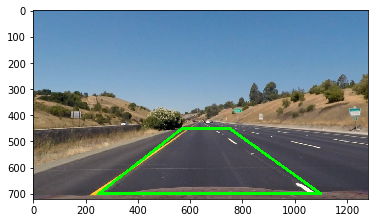

In [9]:
testCalImg ='test_images/straight_lines1.jpg'
testCalImg = mpimg.imread(testCalImg)

sizey,sizex = testCalImg.shape[:2]
srcPts = np.float32([(575,464),
                     (707,464), 
                     (1049,682),
                     (258,682)])

srcPtsInt = np.float32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = np.int32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = srcPtsInt.reshape((-1,1,2))

dstPts = np.float32([(450,0),
                     (sizex-450,0),
                     (sizex-450,sizey),
                     (450,sizey)])

testUndist = undistortImage(testCalImg, mtx, dist)

testUndistRect = np.copy(testUndist)
testUndistRect = cv2.polylines(testUndistRect, [srcPtsInt], True, (0,255,0), 10)


testWarpImg, M, Minv = unWarpImage(testUndist, srcPts, dstPts, imgxy)
plt.imshow(testUndistRect)

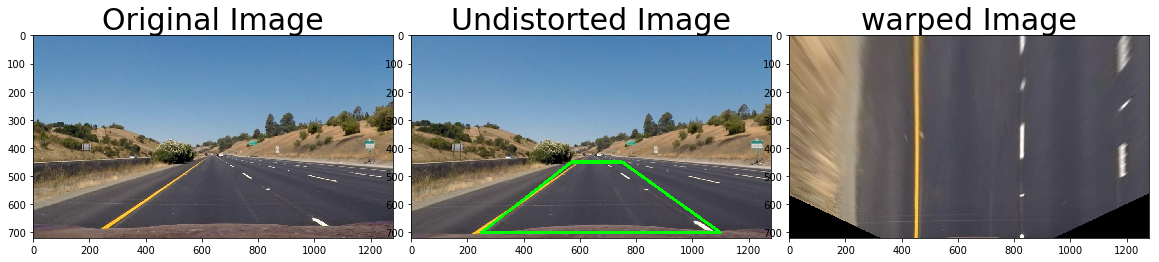

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(testCalImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(testUndistRect)
ax2.set_title('Undistorted Image', fontsize=30) 
ax3.imshow(testWarpImg)
ax3.set_title('warped Image', fontsize=30) 


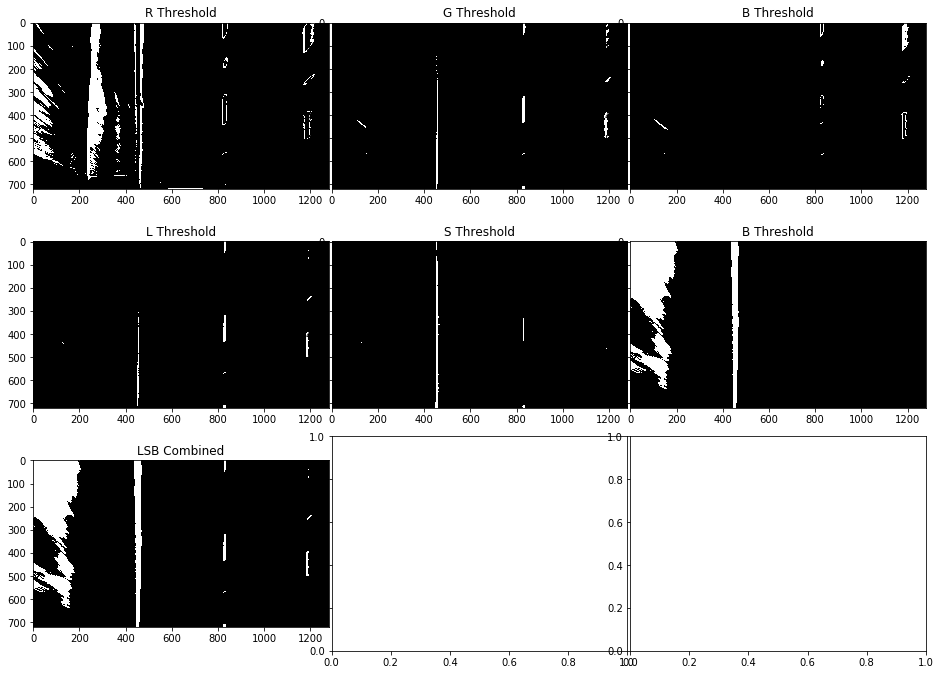

In [11]:
#Test color channels
Imgs = []
ImgNames = []

testWarpImgGray = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2GRAY)

R, G, B = getColorChannelImages(testWarpImg)

RThresh = colorThreshold(R, tLow = 100, tHigh=150)
GThresh = colorThreshold(G, tLow = 190, tHigh=255)
BThresh = colorThreshold(B, tLow = 150, tHigh=200)

Imgs.append(RThresh)
ImgNames.append('R Threshold')
Imgs.append(GThresh)
ImgNames.append('G Threshold')
Imgs.append(BThresh)
ImgNames.append('B Threshold')

testWarpImgHLS = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2HLS)
H, L, S = getColorChannelImages(testWarpImgHLS)

testWarpImgLAB = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2Lab)
L, A, B = getColorChannelImages(testWarpImgLAB)

sColor = np.dstack(( np.zeros_like(S), S, S))*255
SGray = cv2.cvtColor(sColor, cv2.COLOR_RGB2GRAY)

#Normalize L image: for filtering Yellow lines
LNorm = L*(255/np.max(L))
LThresh = colorThreshold(LNorm, tLow=210, tHigh=255)

SThresh = colorThreshold(S, tLow=150, tHigh=255)

#Normalize only for non-yellow lines
if np.max(B) > 175:
    BNorm = B*(255/np.max(B))
else:
    BNorm = np.copy(B)
        
BThresh = colorThreshold(BNorm, tLow=183, tHigh=255)

Imgs.append(LThresh)
ImgNames.append('L Threshold')
Imgs.append(SThresh)
ImgNames.append('S Threshold')
Imgs.append(BThresh)
ImgNames.append('B Threshold')

combined = np.zeros_like(LThresh)
combined[(LThresh == 1) | (BThresh == 1)] = 1
Imgs.append(combined)
ImgNames.append('LSB Combined')


displayImages(Imgs, cmap='gray', ImgTitles=ImgNames, nCols=3)

### I have decided not to use Sobel for this exercise because it is failing in certain cases
### Colors give me enough information to detect lanes

In [14]:
# apply gradient threshold on the horizontal gradient
#xSobel_binary = absSobelXTreshold(LGray, kernelSize=21, tLow=50, tHigh=150)
#Imgs.append(xSobel_binary)
#ImgNames.append('sobelX')

#apply magnitude threshold 
#magSobel_binary = magSobelThreshold(LGray, kernelSize=15, tLow=20, tHigh=200)
#Imgs.append(magSobel_binary)
#ImgNames.append('sobelMag')

#combinedSobel = np.zeros_like(xSobel_binary)
#combinedSobel = ((xSobel_binary == 1) | (magSobel_binary == 1))
#Imgs.append(combinedSobel)
#ImgNames.append('combinedSobel')

#allCombined = np.zeros_like(combined)
#allCombined[combined & combinedSobel] = 1

#Imgs.append(allCombined)
#ImgNames.append('allCombined')


## APPLY PROCESSIMAGE function

In [15]:
#ProcessImageDbg also returns intermittent results for the image
def ProcessImageDbg(img, mtx, dist, srcPts, dstPts, srcPtsInt):
    ###testCalImg = mpimg.imread(testCalImg)
    
    #TestImgs.append(img)
    #TestImgNames.append('Orignal Image')
    
    #1: Undistort the image
    testUndist = undistortImage(img, mtx, dist)
    
    #testUndistRect = np.copy(testUndist)
    #testUndistRect = cv2.polylines(testUndistRect, [srcPtsInt], True, (0,255,0), 10)
    
    #2: Unwarp the image
    testWarpImg, M, Minv = unWarpImage(testUndist, srcPts, dstPts, imgxy)
    TestImgs.append(testWarpImg)
    TestImgNames.append('unWarped')
    
    #3: Color transforms
    #3.1: Gray scale of the image
    testWarpImgGray = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2GRAY)
    
    #3.2: HLS transform of the image
    testWarpImgHLS = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2HLS)    
    H, L, S = getColorChannelImages(testWarpImgHLS)
    
    #3.3: lAB transform of the image
    testWarpImgLAB = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2Lab)
    L, A, B = getColorChannelImages(testWarpImgLAB)
    
    #3.4: RYB transform of the image
    testWarpImgLAB = cv2.cvtColor(testWarpImg, cv2.COLOR_RGB2Lab)
    L, A, B = getColorChannelImages(testWarpImgLAB)
    
    
    #sColor = np.dstack(( np.zeros_like(S), S, S))*255
    #SGray = cv2.cvtColor(sColor, cv2.COLOR_RGB2GRAY)
    
    #3.4: Color threshold 
    #Normalize L image: for filtering Yellow lines
    LNorm = L*(255/np.max(L))
    LThresh = colorThreshold(L, tLow=210, tHigh=255) #210, 255
    TestImgs.append(LThresh)
    TestImgNames.append('L Threshold')
    
    SThresh = colorThreshold(S, tLow=150, tHigh=255)
    TestImgs.append(SThresh)
    TestImgNames.append('S Threshold')
    
    #Normalize only for non-yellow lines
    if np.max(B) > 175:
        BNorm = B*(255/np.max(B))
    else:
        BNorm = np.copy(B)
        
    BThresh = colorThreshold(B, tLow=183, tHigh=255) #160 220
    TestImgs.append(BThresh)
    TestImgNames.append('B Threshold')

    combined = np.zeros_like(LThresh)
    #combined[(LThresh == 1) | (SThresh == 1) | (BThresh == 1)] = 1
    combined[(LThresh == 1) | (BThresh == 1)] = 1
    TestImgs.append(combined)
    TestImgNames.append('Combined Image')
    
    return TestImgs, TestImgNames, M, Minv

## APPLY IMAGE TRANSFORM

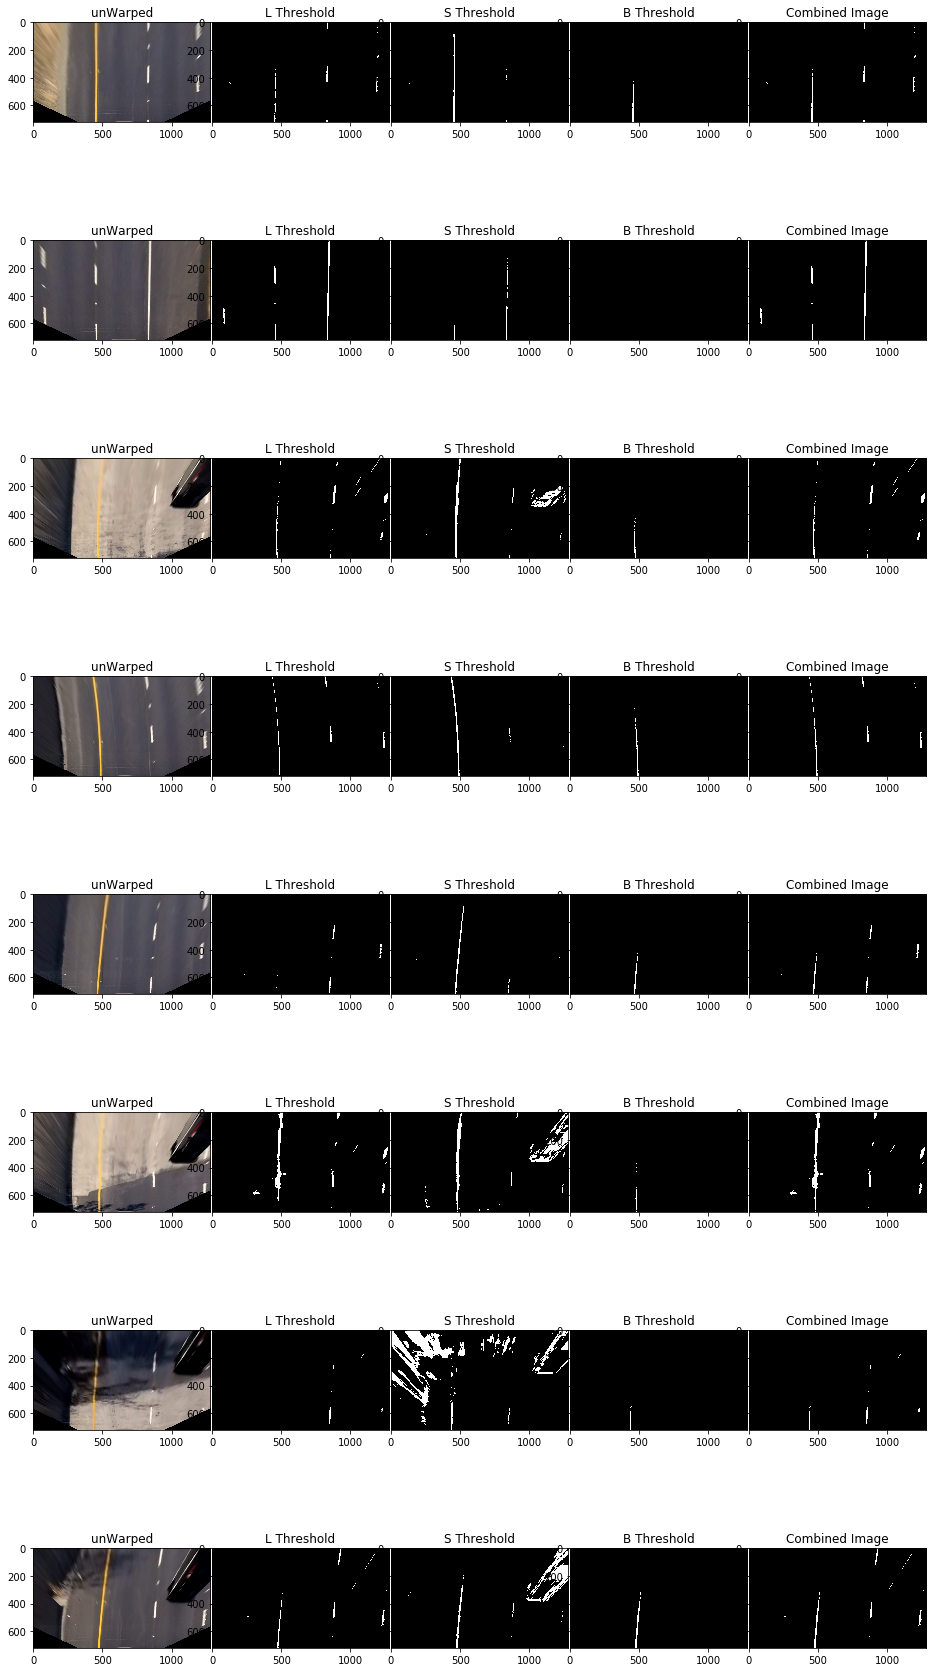

In [16]:
TestImgs = []
TestImgNames = []

fileNames = os.listdir("test_images/")

srcPts = np.float32([(575,464),
                     (707,464), 
                     (1049,682),
                     (258,682)])
srcPtsInt = np.int32([(575,464),
                     (707,464), 
                     (1049,682), 
                     (258,682)])

srcPtsInt = srcPtsInt.reshape((-1,1,2))

dstPts = np.float32([(450,0),
                     (sizex-450,0),
                     (sizex-450,sizey),
                     (450,sizey)])

for imgName in fileNames:        
    img = mpimg.imread("test_images/"+imgName)
    TestImgs, TestImgNames, M, Minv = ProcessImageDbg(img, mtx, dist, srcPts, dstPts, srcPtsInt)
    
displayImages(TestImgs, cmap='gray', ImgTitles=TestImgNames, nCols=5)

## SLIDING WINDOW AND HISTOGRAM

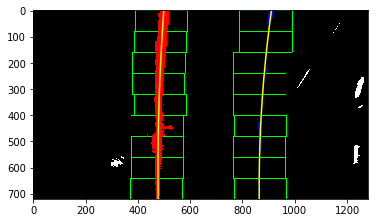

In [17]:
srcPtsInt = np.float32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = np.int32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = srcPtsInt.reshape((-1,1,2))

dstPts = np.float32([(450,0),
                     (sizex-450,0),
                     (sizex-450,sizey),
                     (450,sizey)])

testCalImg ='test_images/test4.jpg'
testCalImg = mpimg.imread(testCalImg)
warpBinImg, M, Minv = ProcessImage(testCalImg , mtx, dist, srcPts, dstPts, srcPtsInt)

left_fit, right_fit, left_lane_inds, right_lane_inds, WindowsNHist = sliding_window_polyfit(warpBinImg)

#fit polynomial
h = warpBinImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

#Extract windows and historgram to plot on the image
Windows = WindowsNHist[0]
histogram = WindowsNHist[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((warpBinImg, warpBinImg, warpBinImg))*255)
plt.imshow(out_img)

# Generate x and y values for plotting
ploty = np.linspace(0, warpBinImg.shape[0]-1, warpBinImg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#iterate over number of windows to plot them
for rect in Windows:
    # Draw the windows on the image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warpBinImg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

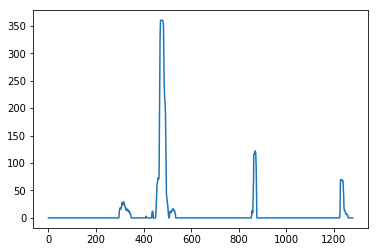

In [18]:
#Notice for binarywarped image 5, there are multiple peaks and original window of midpoint failed
#The identified lane was from the last peak, so decided to do mid point of midpoint
#plot Histogram 
plt.plot(histogram)

## POLYSEARCH

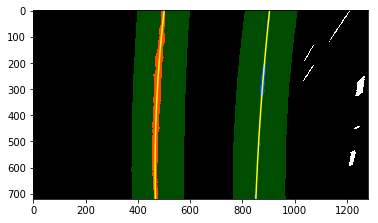

In [19]:
srcPtsInt = np.float32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = np.int32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = srcPtsInt.reshape((-1,1,2))

dstPts = np.float32([(450,0),
                     (sizex-450,0),
                     (sizex-450,sizey),
                     (450,sizey)])

margin = 100;

testCalImg ='test_images/test1.jpg'
testCalImg = mpimg.imread(testCalImg)
warpBinImg, M, Minv = ProcessImage(testCalImg , mtx, dist, srcPts, dstPts, srcPtsInt)
left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = search_around_poly(warpBinImg, left_fit, right_fit, margin=100)

#Now plot lanes and 
ploty = np.linspace(0, warpBinImg.shape[0]-1, warpBinImg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx_new = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx_new = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((warpBinImg, warpBinImg, warpBinImg))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = warpBinImg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx_new, ploty, color='yellow')
plt.plot(right_fitx_new, ploty, color='yellow')


## CURVATURE AND VEHICLE OFFSET

In [20]:
leftRad, rightRad = measure_curvature_real(warpBinImg, left_lane_inds_new, right_lane_inds_new)
print('Right Lane Curvature:', rightRad, 'm')
print('Left Lane Curvature:', leftRad, 'm')

Right Lane Curvature: 3516.20328671 m
Left Lane Curvature: 1719.58365524 m


In [21]:
VehOffset = CalcVehLaneOffset(warpBinImg, left_fit, right_fit)
print('VehOffset: ', VehOffset)

VehOffset:  -0.163442378994


## PLOT LANE AND WRITE DATA

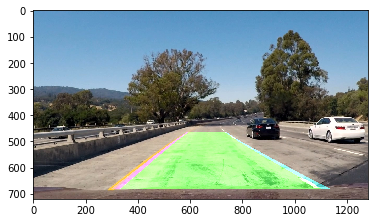

In [22]:
outFrame = plotLinesOnFrame(testCalImg, warpBinImg, left_fit, right_fit, Minv)
plt.imshow(outFrame)

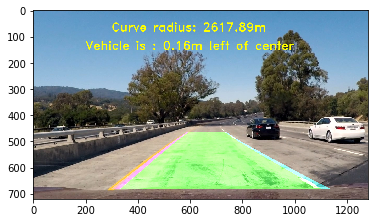

In [23]:
outImg = printVehRoadData(outFrame, (leftRad+rightRad)/2, VehOffset)
plt.imshow(outImg)

## PROCESS VIDEO

In [24]:
#Define default data required for processing the video
srcPtsInt = np.float32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = np.int32([(570,450),
                     (750,450), 
                     (1100,700),
                     (250,700)])

srcPtsInt = srcPtsInt.reshape((-1,1,2))

dstPts = np.float32([(450,0),
                     (sizex-450,0),
                     (sizex-450,sizey),
                     (450,sizey)])
margin = 100;

#Initialize line objects for lane lines
leftLine = Line()
rightLine = Line()


In [25]:
#testwarpBinImg, M, Minv = ProcessImage(testCalImg , mtx, dist, srcPts, dstPts, srcPtsInt)
#left_fit, right_fit, left_lane_inds, right_lane_inds, WindowsNHist = sliding_window_polyfit(testwarpBinImg)
#outFrame = plotLinesOnFrame(testCalImg, testwarpBinImg, left_fit, right_fit, Minv)
#plt.imshow(outFrame)

In [26]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4') #.subclip(0,2)
processed_video = video_input1.fl_image(processVideoFrame)
%time processed_video.write_videofile(video_output1, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 4min 28s


In [27]:
#video_output1 = 'challenge_video_output.mp4'
#video_input1 = VideoFileClip('challenge_video.mp4') #.subclip(0,2)
#processed_video = video_input1.fl_image(processVideoFrame)
#%time processed_video.write_videofile(video_output1, audio=False)

In [28]:
#video_output1 = 'harder_challenge_video_output.mp4'
#video_input1 = VideoFileClip('harder_challenge_video.mp4') #.subclip(0,2)
#processed_video = video_input1.fl_image(processVideoFrame)
#%time processed_video.write_videofile(video_output1, audio=False)